# QUESTÃO DE NEGÓCIO

- Foi nos requisitado por um CFO de uma rede de farmácias, a previsão de vendas de todas as lojas pelas proximas 6 semanas, onde ele deseja saber quando deve ser investido em cada uma delas para realizar uma reforma nas lojas.

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

## 0.1 Helper Fuctions

In [2]:
def jupyter_settings(): 
    %matplotlib inline 
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 Descrição dos Dados

In [6]:
df = df_raw.copy()

## 1.1 Rename Columns

In [7]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df.columns = cols_new

## 1.2 Data Dimensions

In [9]:
print('Number of Rows: {}'.format(df.shape[0]))
print('Number of Cols: {}'.format(df.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [10]:
# object to datetime 'date' column
df['date'] = pd.to_datetime(df['date'])
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA's

In [11]:
# competition_distance
df['competition_distance'] = df['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df['competition_open_since_month'] = df.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df['competition_open_since_year'] = df.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df['promo2_since_week'] = df.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df['promo2_since_year'] = df.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df['promo_interval'].fillna(0, inplace=True)

df['month_map'] = df['date'].dt.month.map(month_map)
df['is_promo'] = df[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split (',') else 0, axis=1)

## 1.6 Change types

In [12]:
df['competition_open_since_month'] = df['competition_open_since_month'].astype(int)
df['competition_open_since_year'] = df['competition_open_since_year'].astype(int)
df['competition_distance'] = df['competition_distance'].astype(int)

df['promo2_since_week'] = df['promo2_since_week'].astype(int)
df['promo2_since_year'] = df['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [13]:
# numerical attributes
num_attributes = df.select_dtypes (include=['int64', 'float64'])

# categorical attributes
cat_attributes = df.select_dtypes (exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

# concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

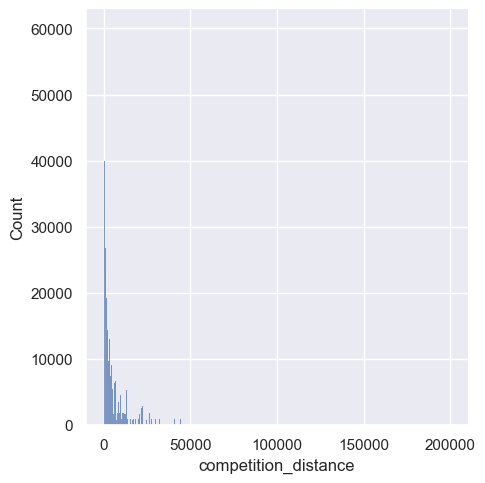

In [15]:
sns.displot(df['competition_distance'], kde=False)

### 1.7.2 Categorical attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

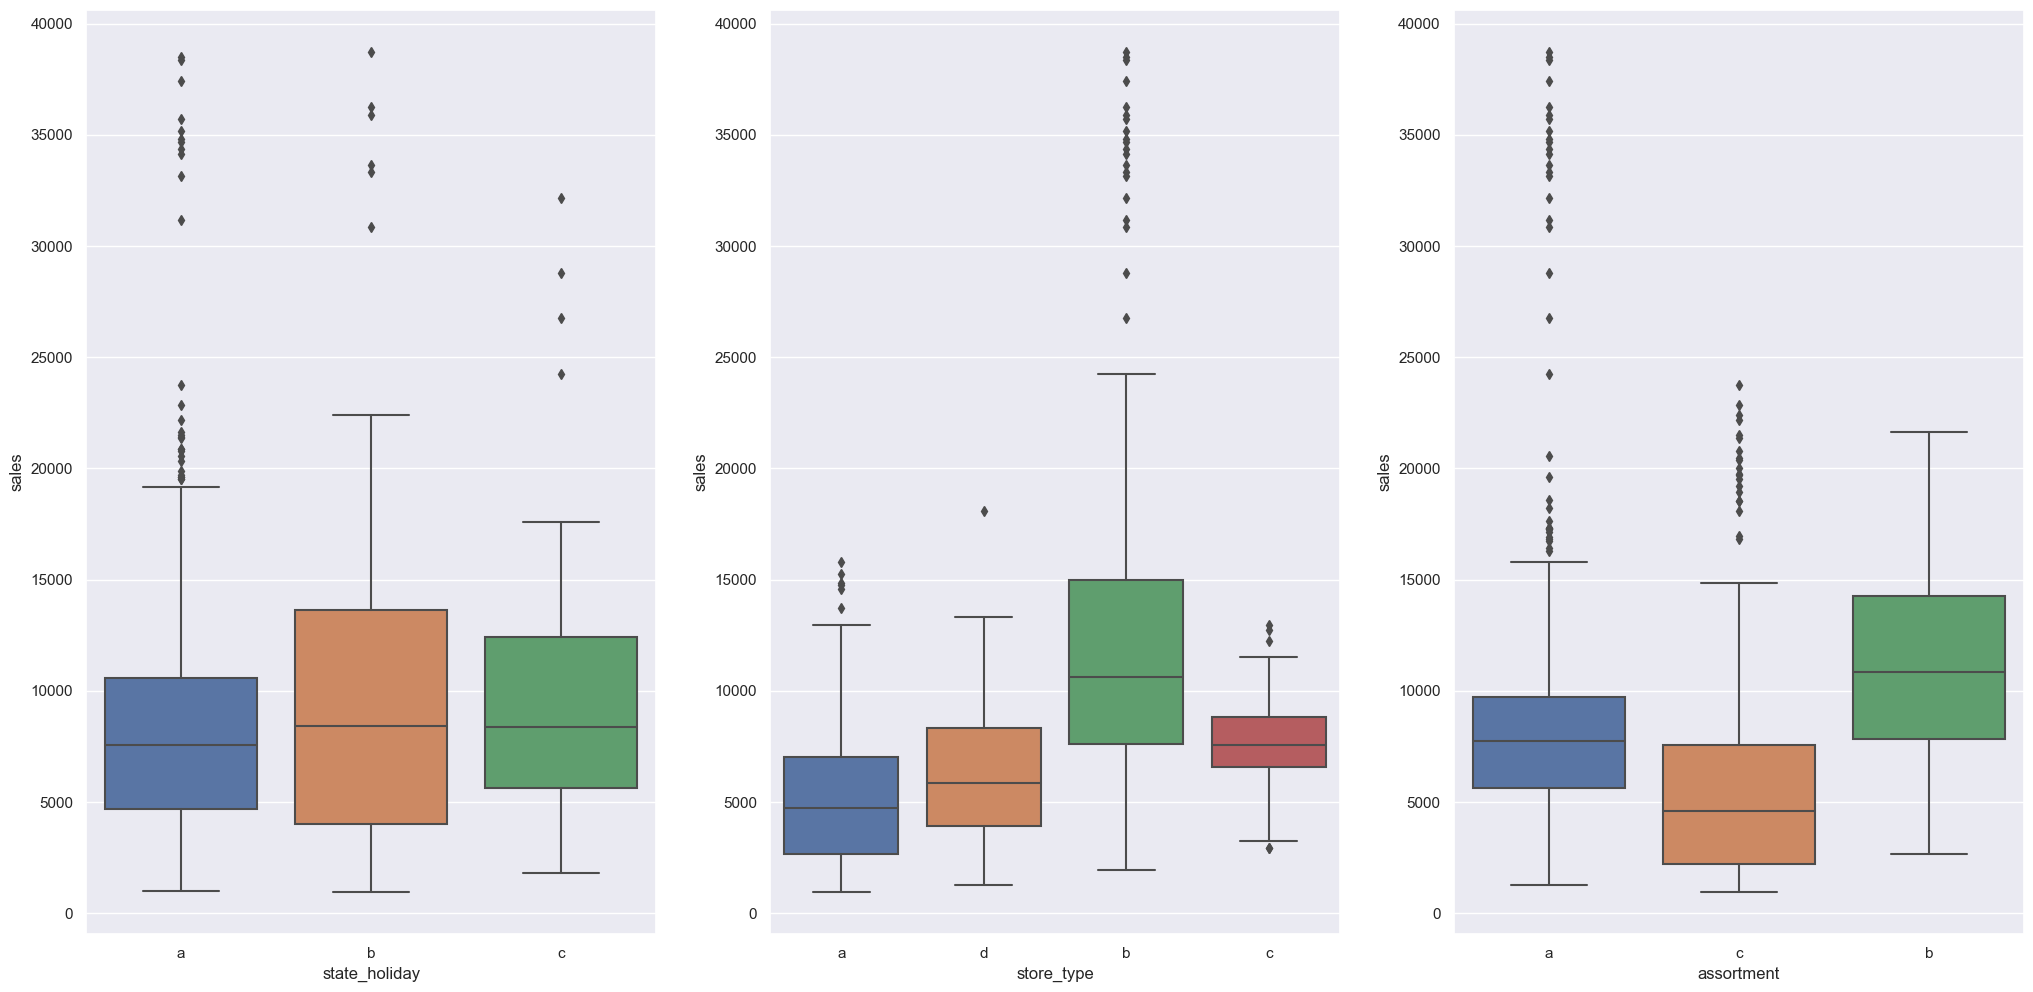

In [17]:
aux = df[(df['state_holiday'] !='0') & (df['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot (x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot (x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot (x='assortment', y='sales', data=aux)

# 2.0 Feature Engineering

In [18]:
df2 = df.copy()

## 2.1 Mapa mental de hipoteses

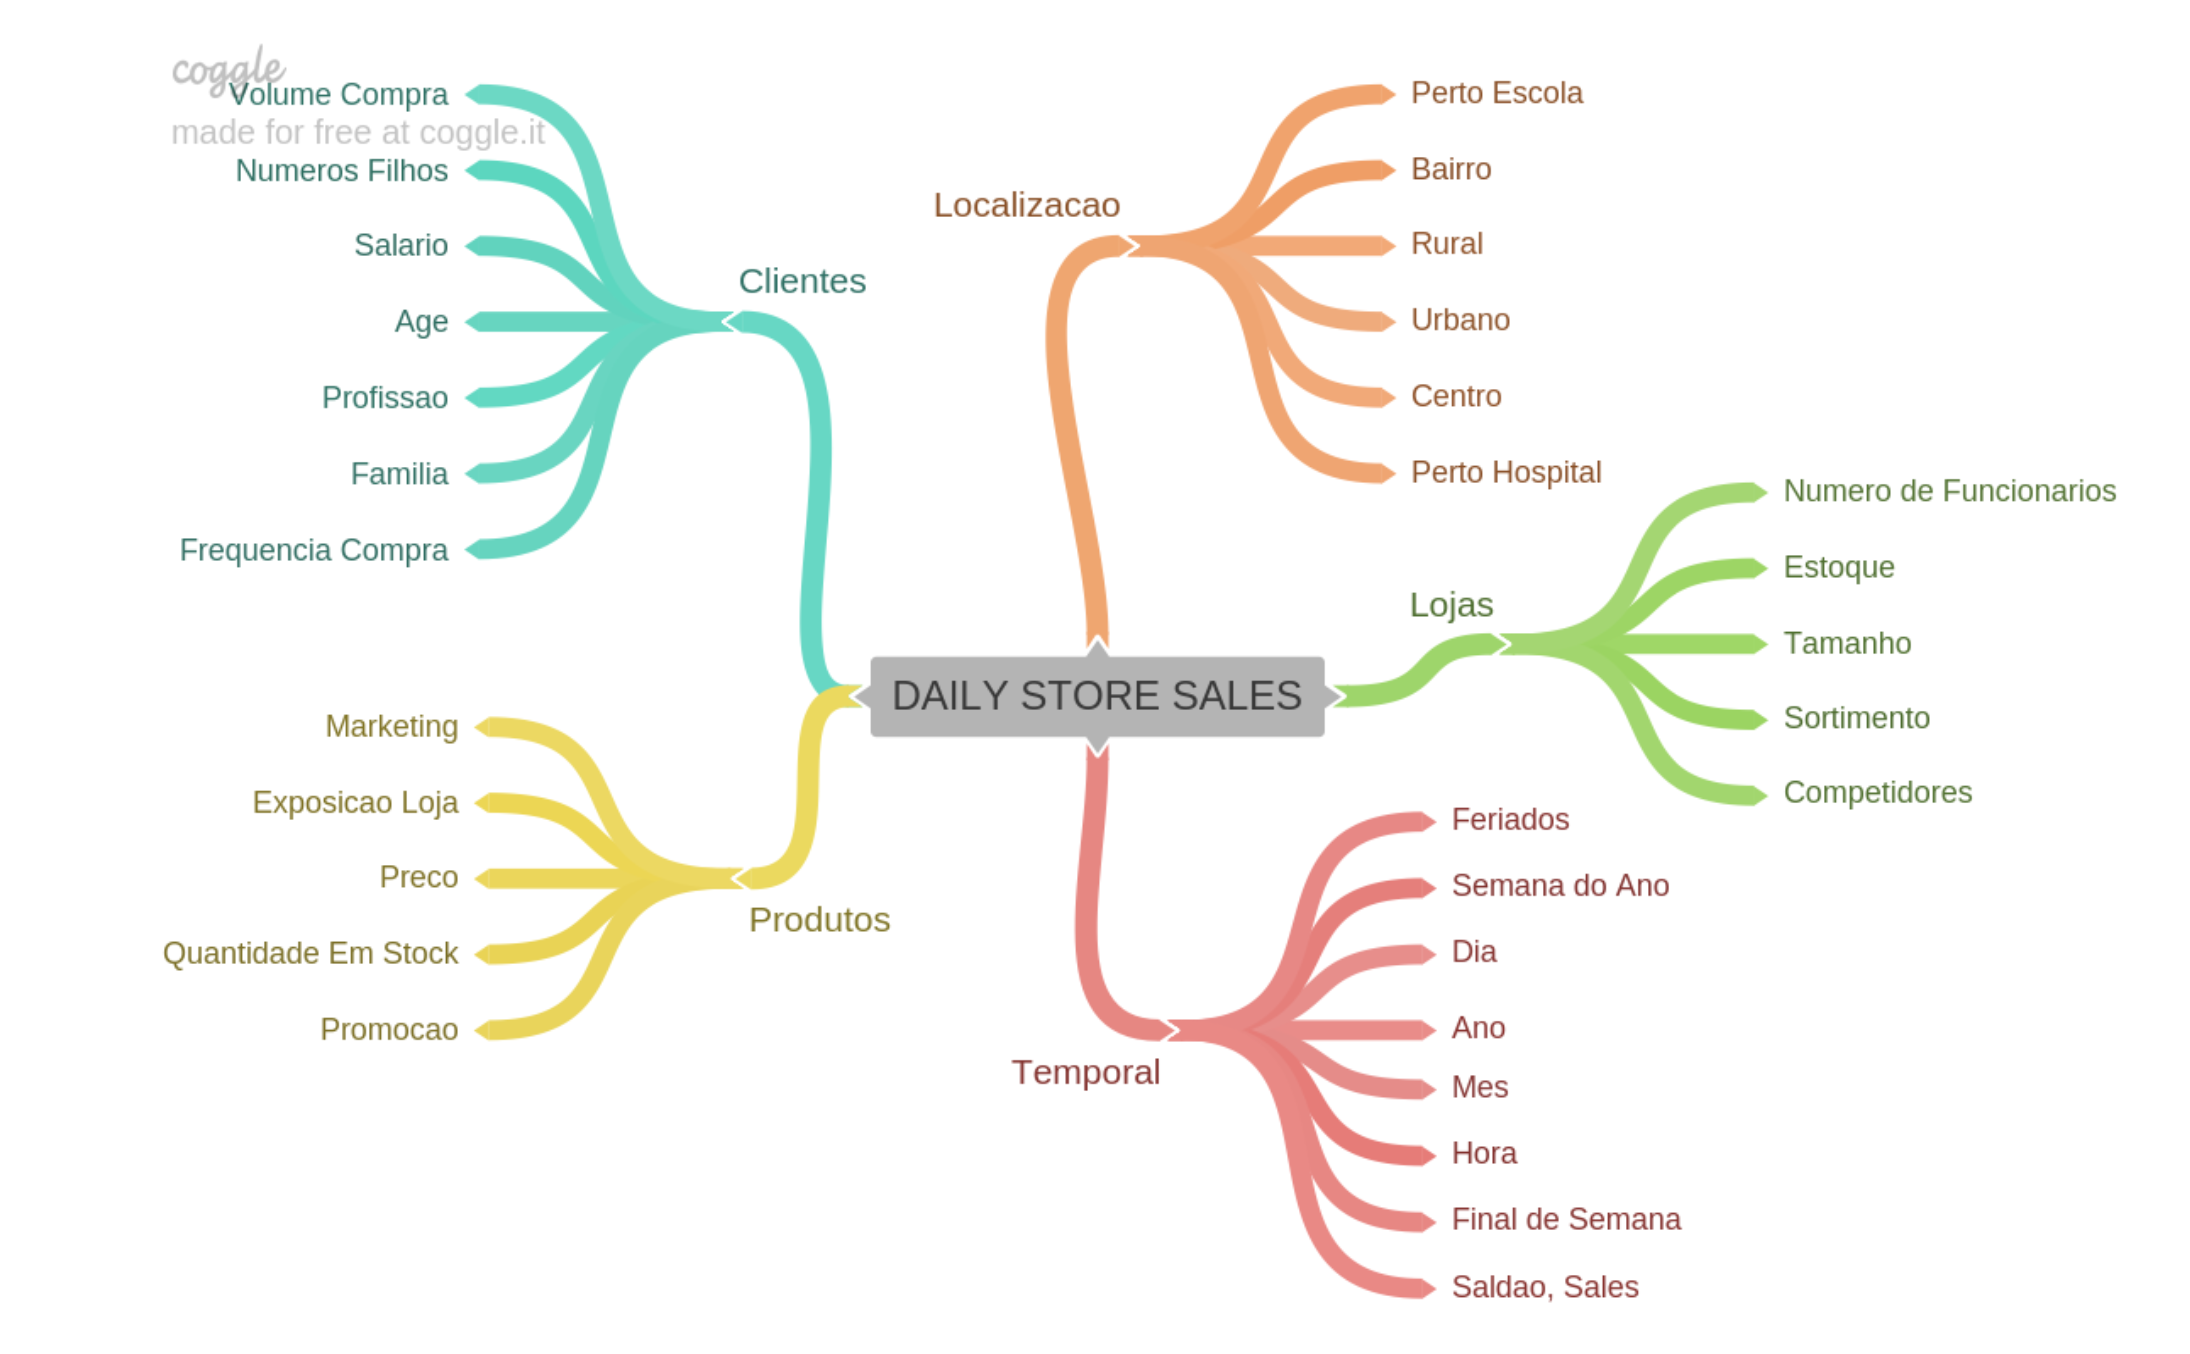

In [19]:
Image('img/mind_map.png')

## 2.2 Lista final de hipoteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais. 
8. Lojas abertas durante o feriado de Natal deveriam vender mais. 
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [20]:
# year 
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day 
df2['day'] = df2['date'].dt.day

# week of year
#df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W-')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extended' if x== 'b' else 'extra')

# 3.0 Filtragem das Variáveis

In [21]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 Análise Exploratória

In [24]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

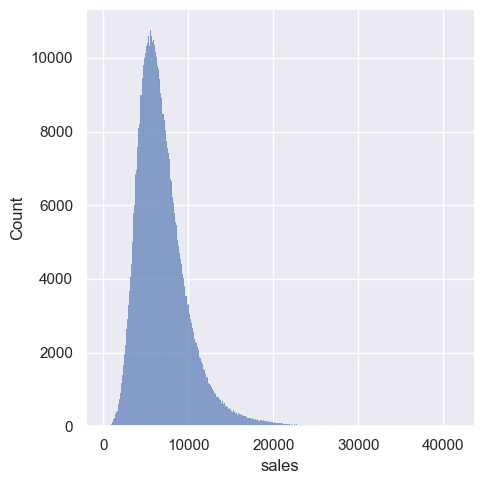

In [25]:
sns.displot( df4['sales'], kde=False )

### 4.1.2 Numerical Variable

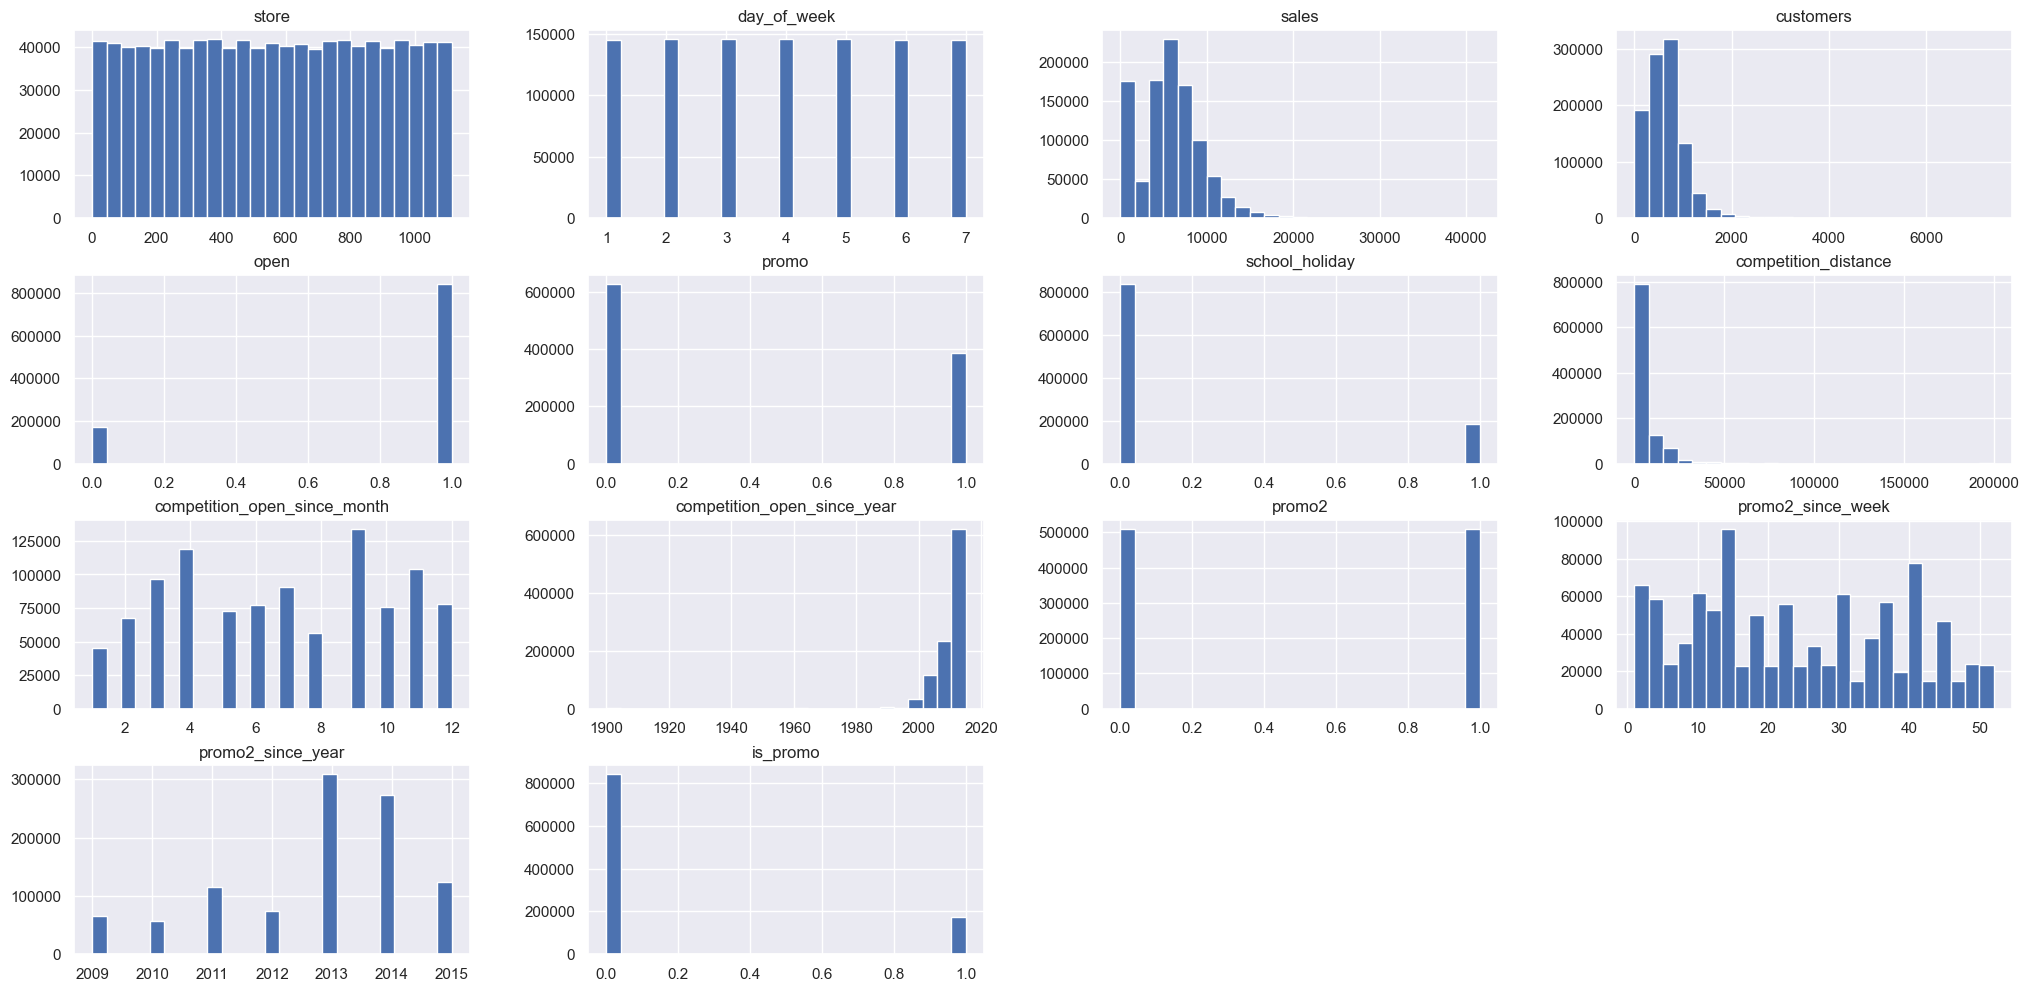

In [26]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

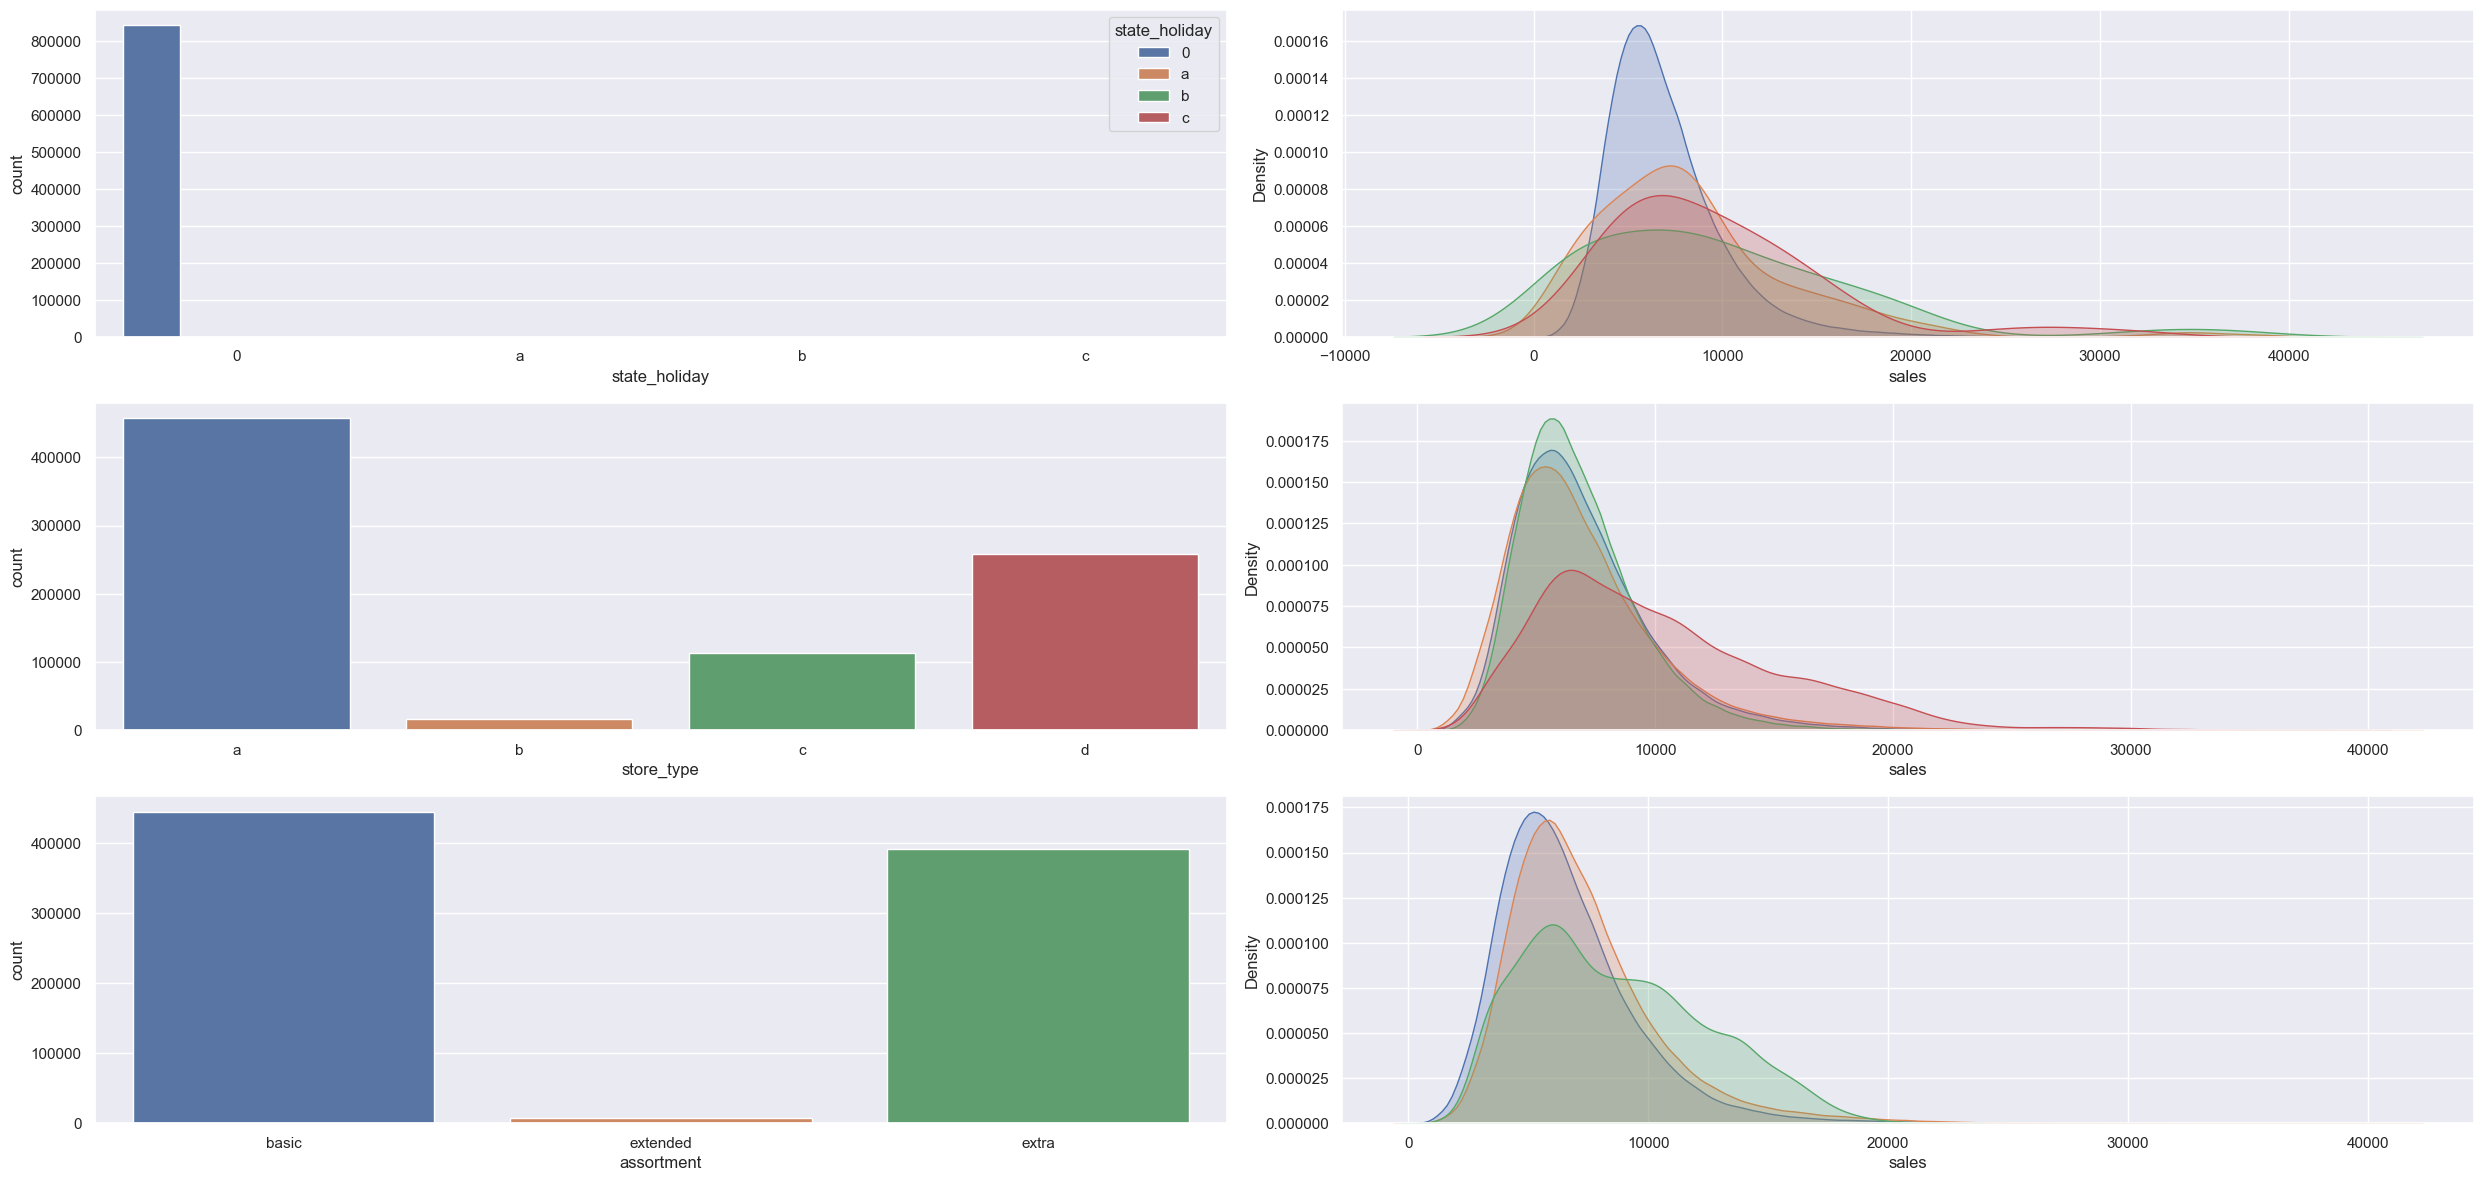

In [27]:
# Converta as colunas para o tipo 'category'

df4['state_holiday'] = df4['state_holiday'].astype('category')
df4['store_type'] = df4['store_type'].astype('category')
df4['assortment'] = df4['assortment'].astype('category')

# state_holiday
plt.subplot(3, 2, 1)
sns.countplot(data=df4, x='state_holiday', hue='state_holiday')

plt.subplot(3, 2, 2)
for holiday in df4['state_holiday'].unique():
    subset = df4[df4['state_holiday'] == holiday]['sales']
    sns.kdeplot(subset, label=holiday, fill=True)
    
plt.xlabel('sales')
plt.ylabel('Density')

# store_type
plt.subplot(3, 2, 3)
sns.countplot(data=df4, x='store_type')

plt.subplot(3, 2, 4)
for store_type in df4['store_type'].unique():
    subset = df4[df4['store_type'] == store_type]['sales']
    sns.kdeplot(subset, label=store_type, fill=True)

plt.xlabel('sales')
plt.ylabel('Density')

# assortment
plt.subplot(3, 2, 5)
sns.countplot(data=df4, x='assortment')

plt.subplot(3, 2, 6)
for assortment in df4['assortment'].unique():
    subset = df4[df4['assortment'] == assortment]['sales']
    sns.kdeplot(subset, label=assortment, fill=True)

plt.xlabel('sales')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

## 4.2 Analise bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

**TRUE** Lojas com maior sortimento vendem mais, lojas com sortimento médio vendem menos.

<Axes: xlabel='year_week'>

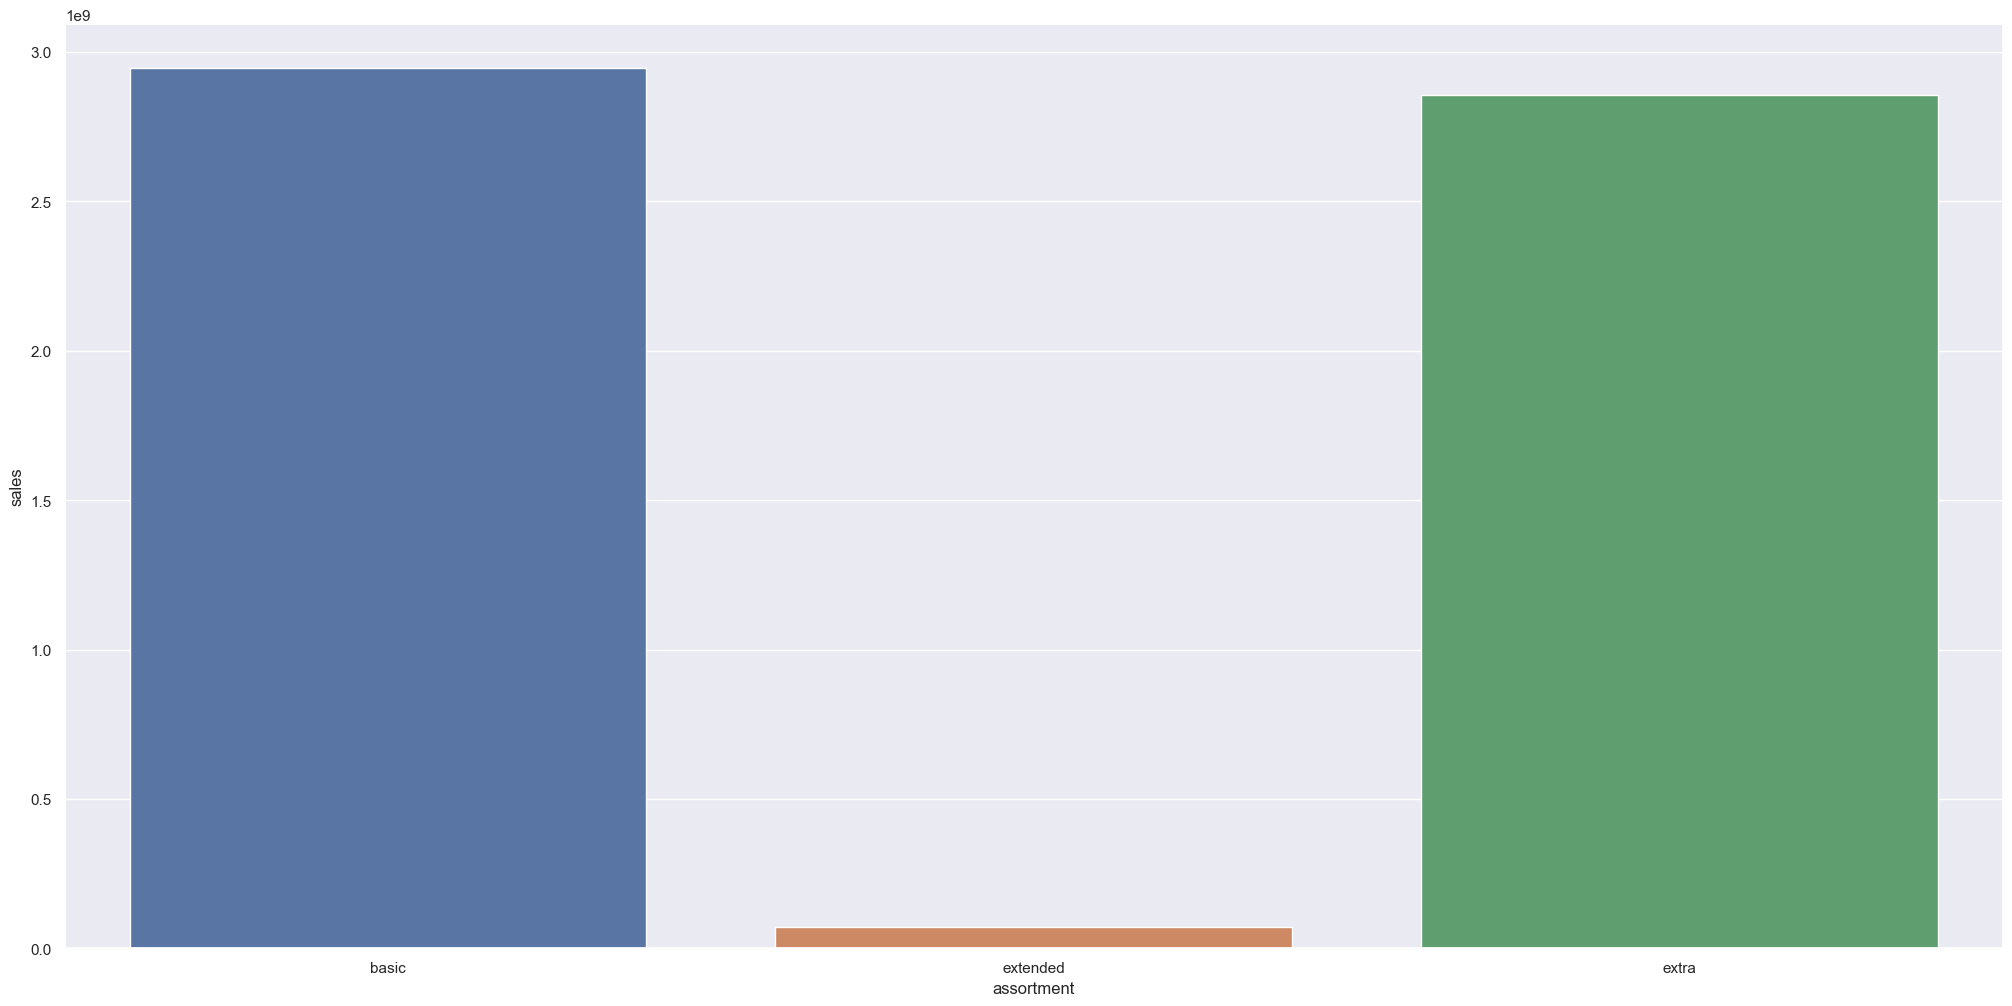

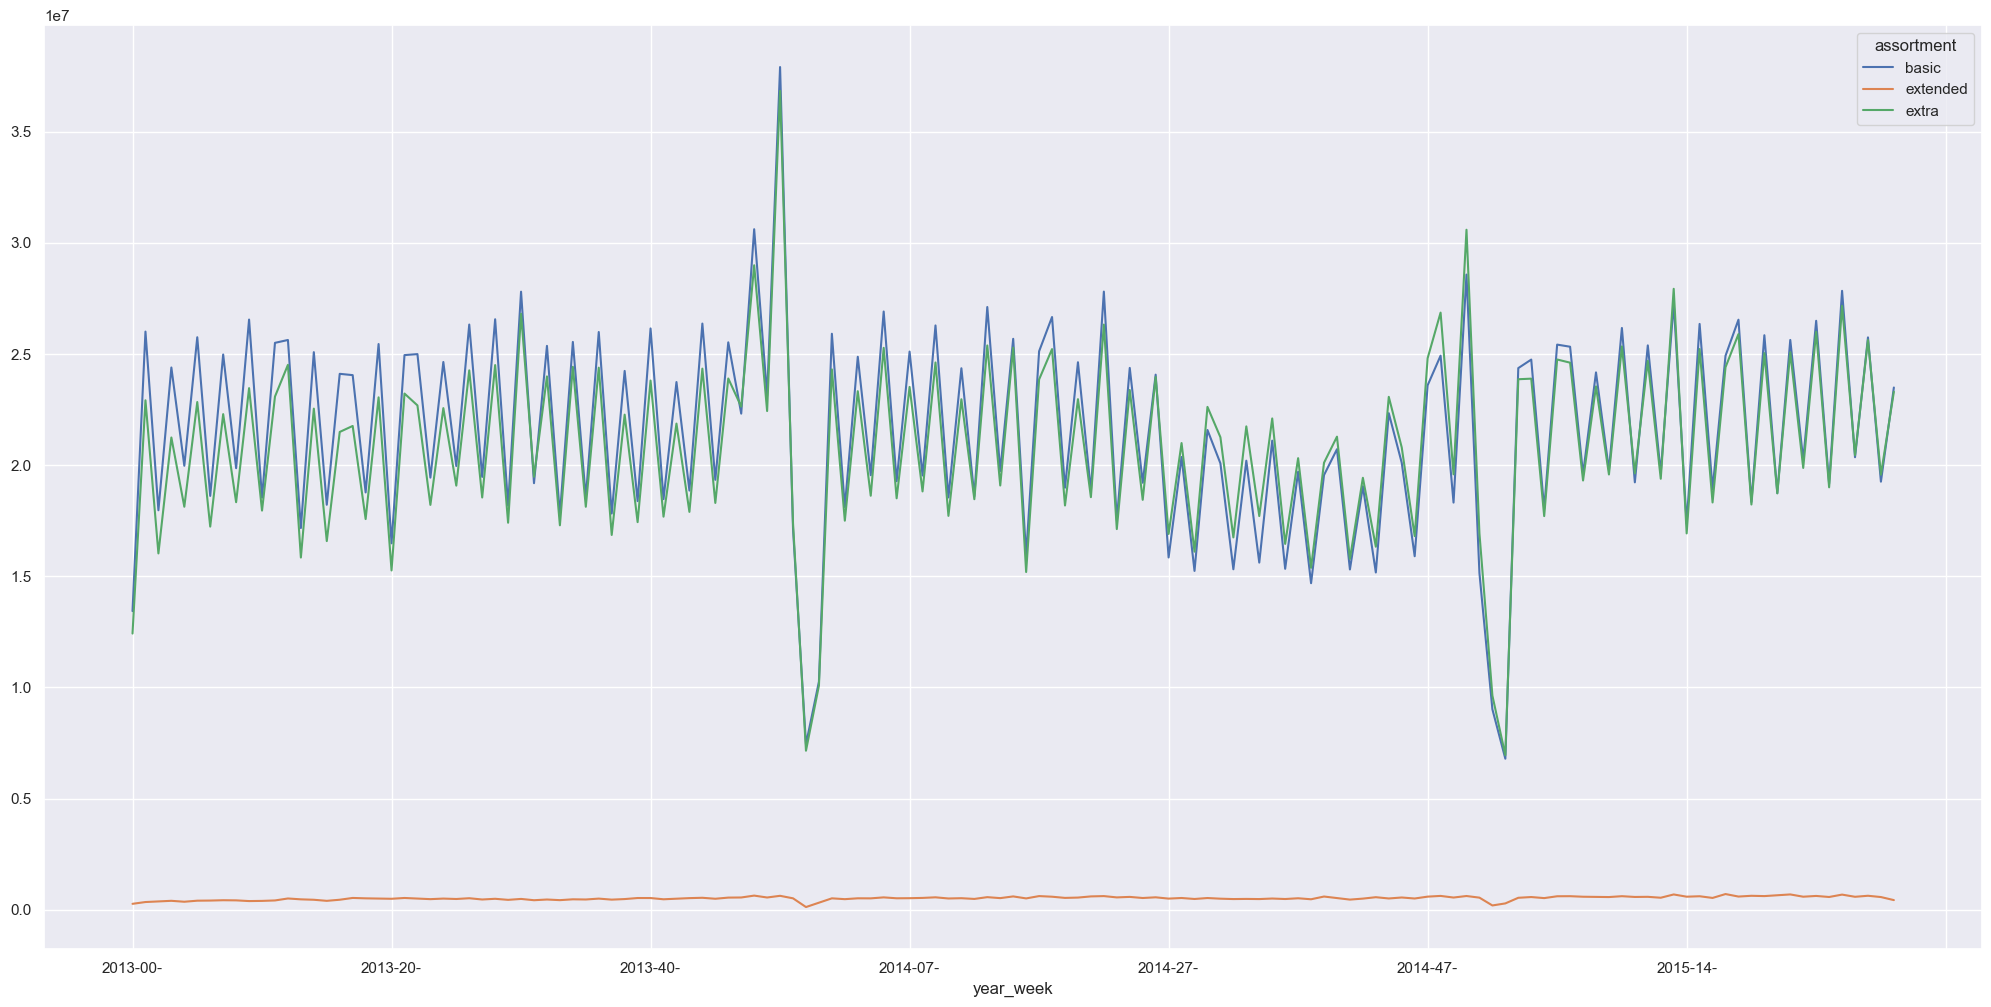

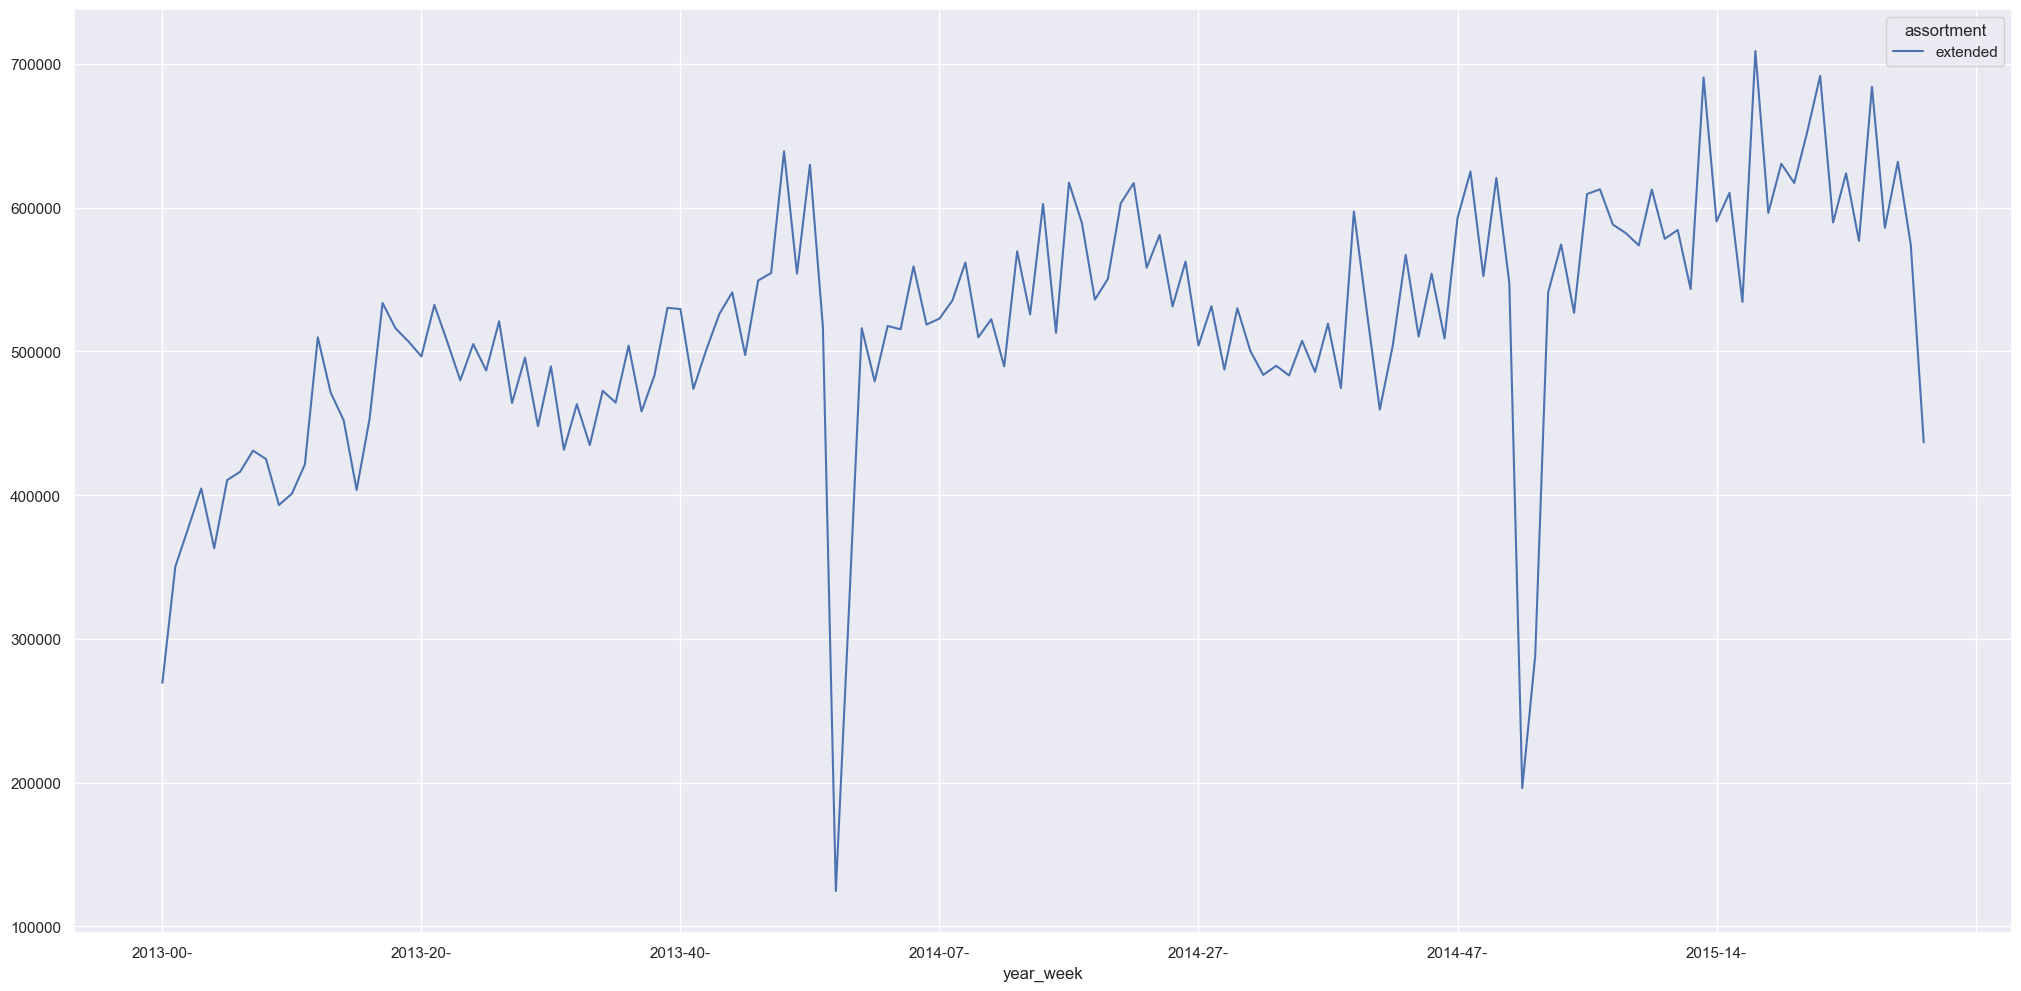

In [28]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y= 'sales', data=aux1 );

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index= 'year_week', columns= 'assortment', values= 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extended']
aux3.pivot(index= 'year_week', columns= 'assortment', values= 'sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

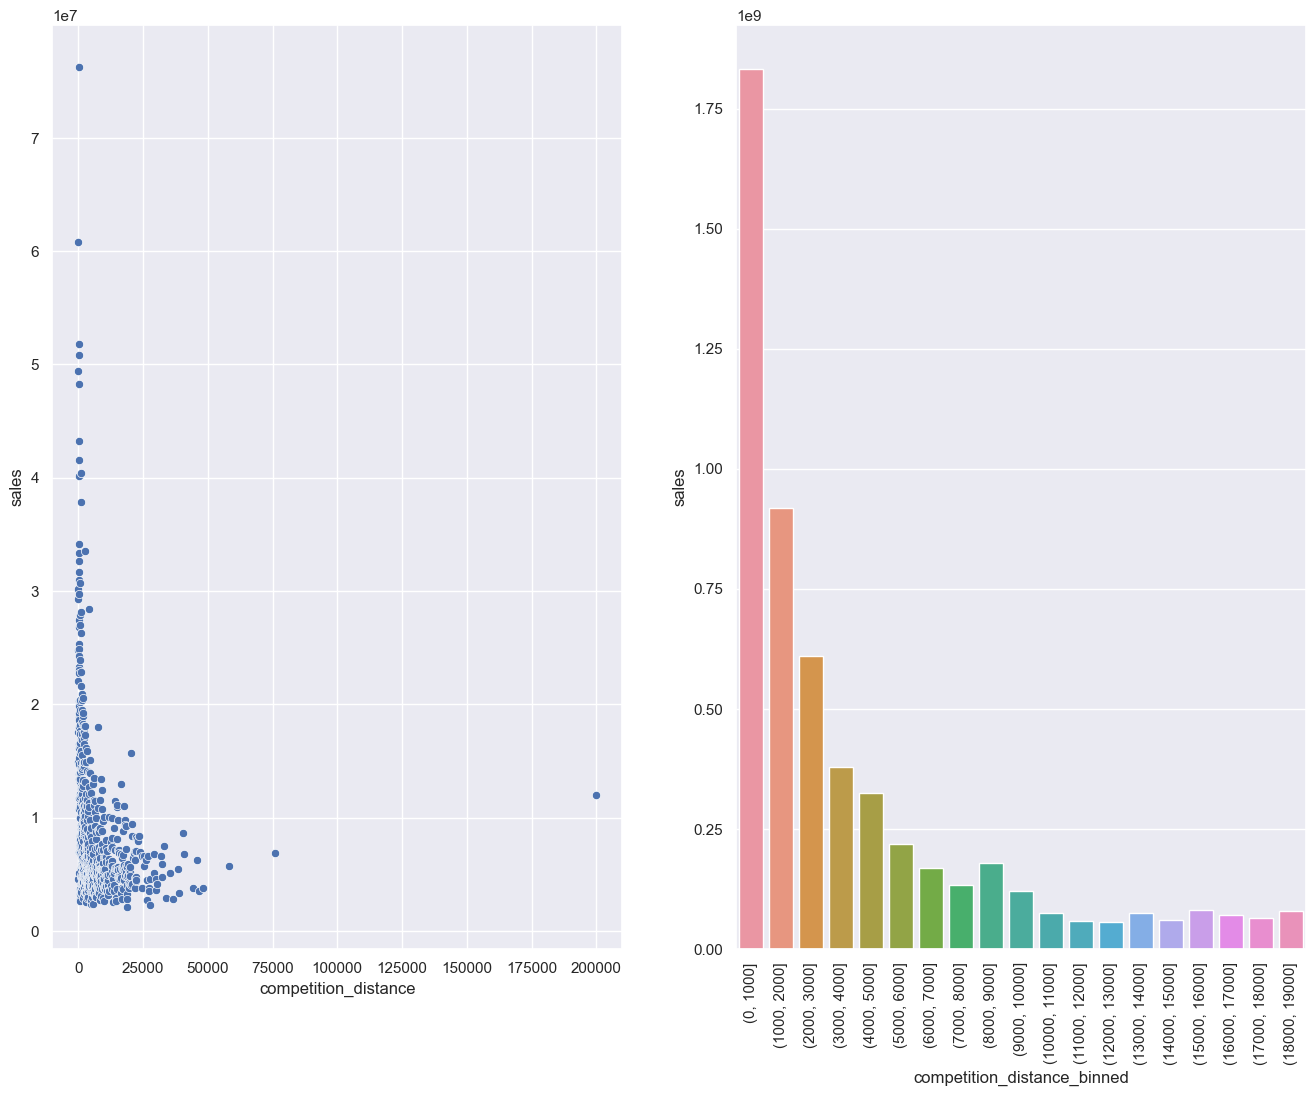

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

#plt.subplot( 1, 3, 3 )
#x = sns.heatmap( aux1.corr( method='pearson' ), annot=True ); 

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
- **FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

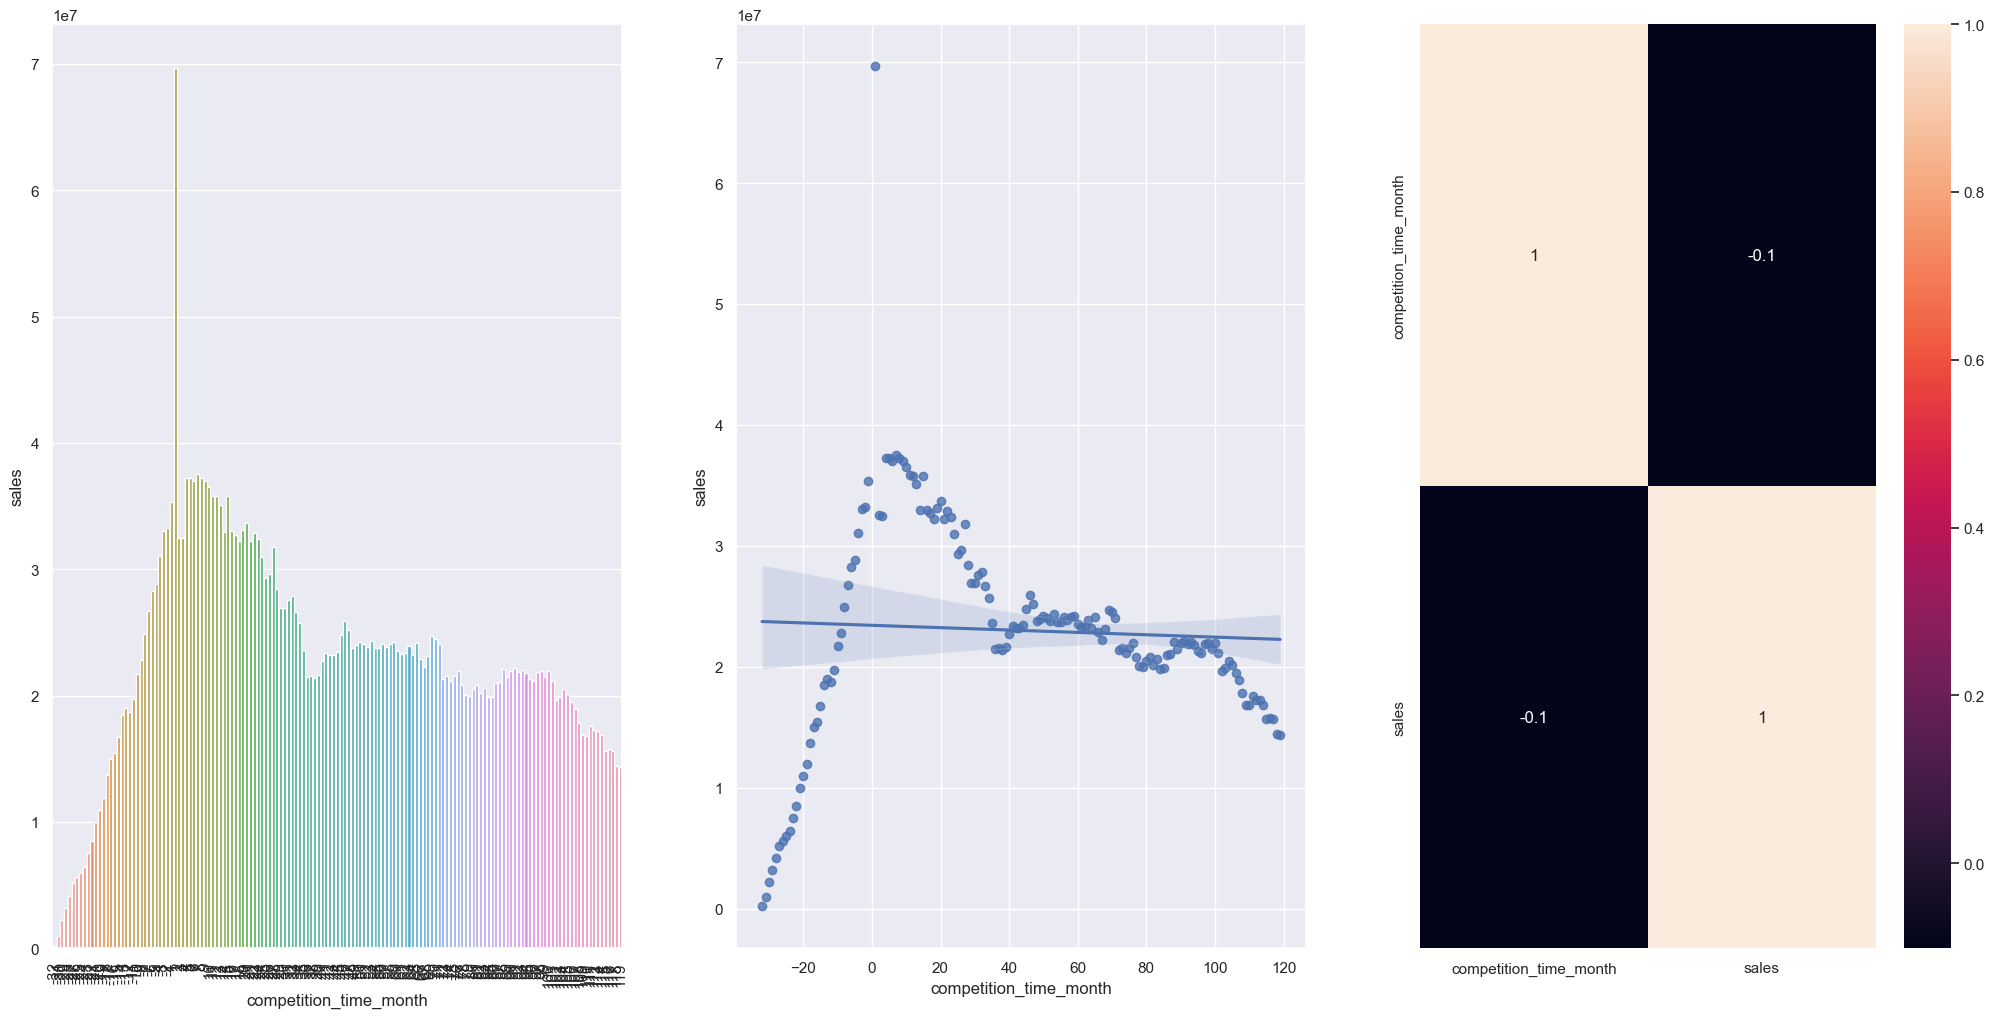

In [34]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 ); 
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
- **FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção.

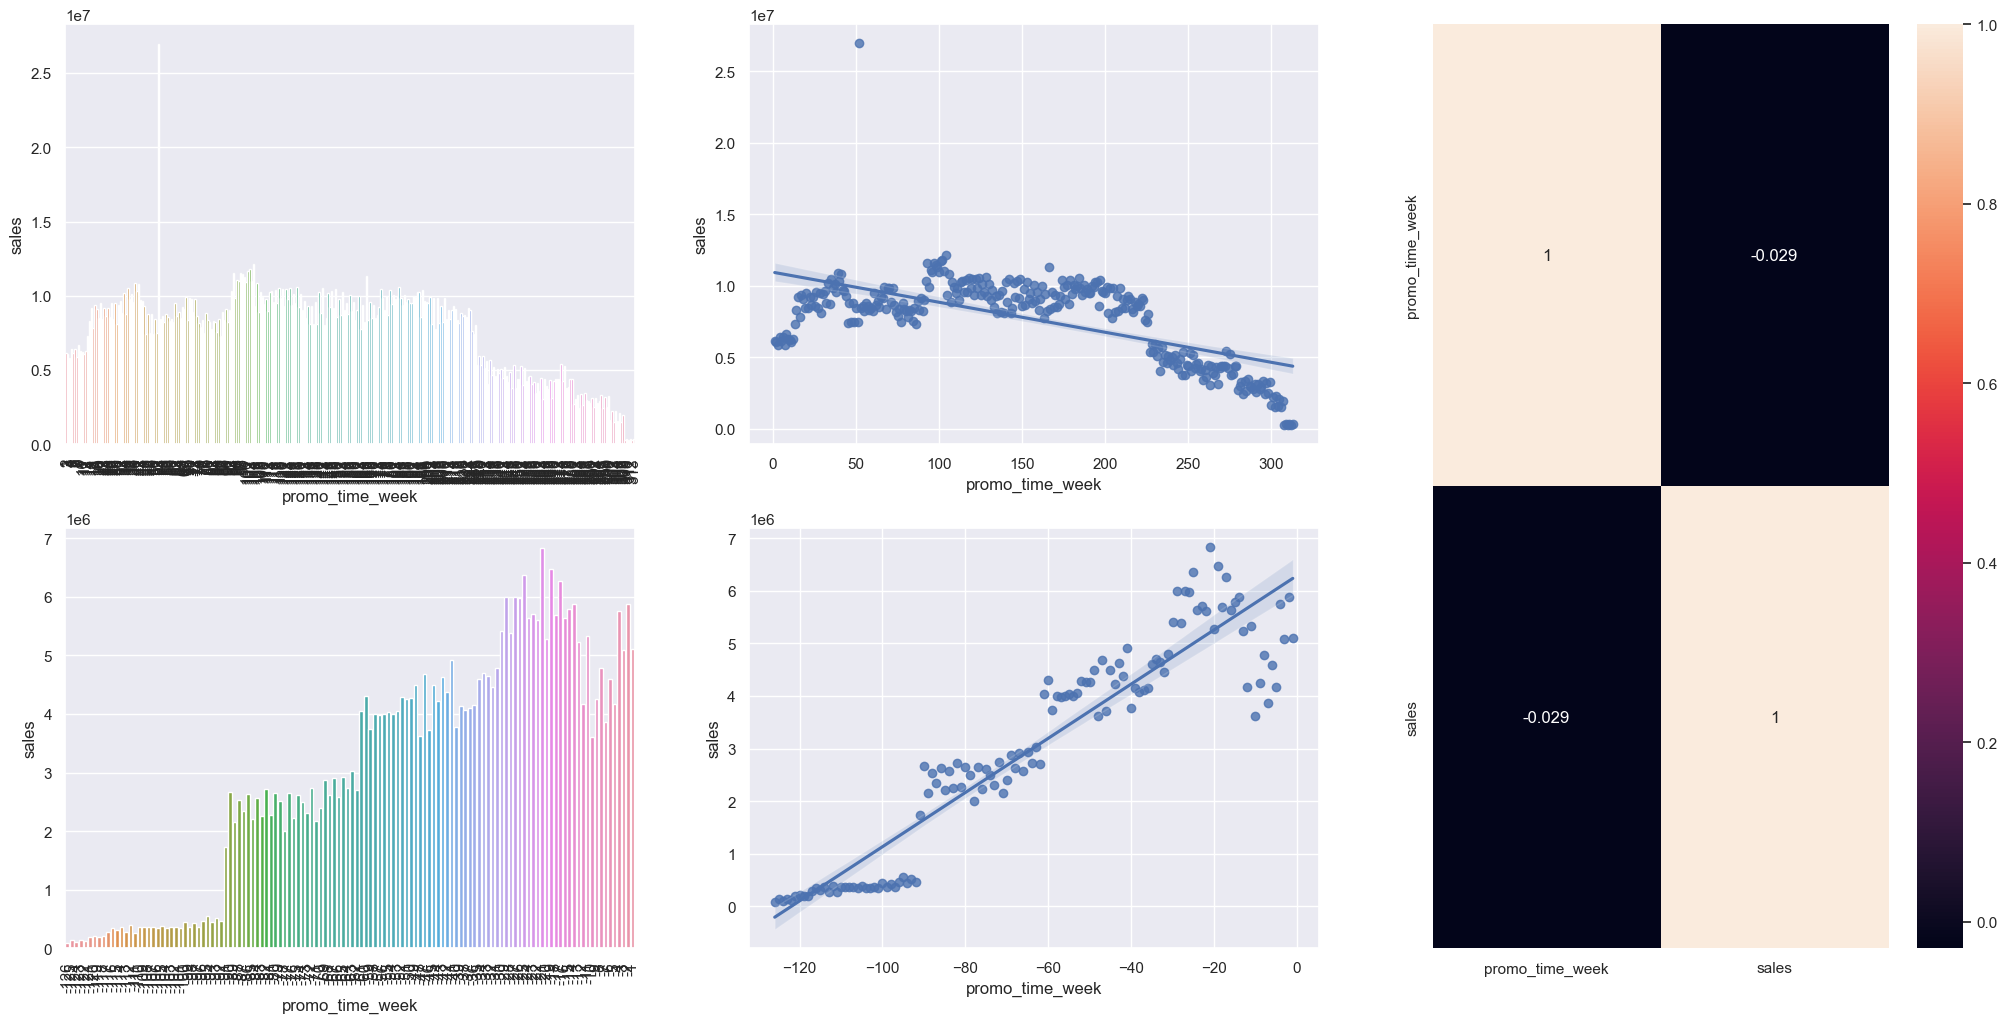

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido 
sns.barplot( x='promo_time_week', y='sales', data=aux2 ); 
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular 
sns.barplot( x='promo_time_week', y='sales', data=aux3 ); 
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H5. Lojas com mais promoções consecutivas deveriam vender mais.
- **FALSA** Lojas com mais promoções consecutivas vendem menos

In [40]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


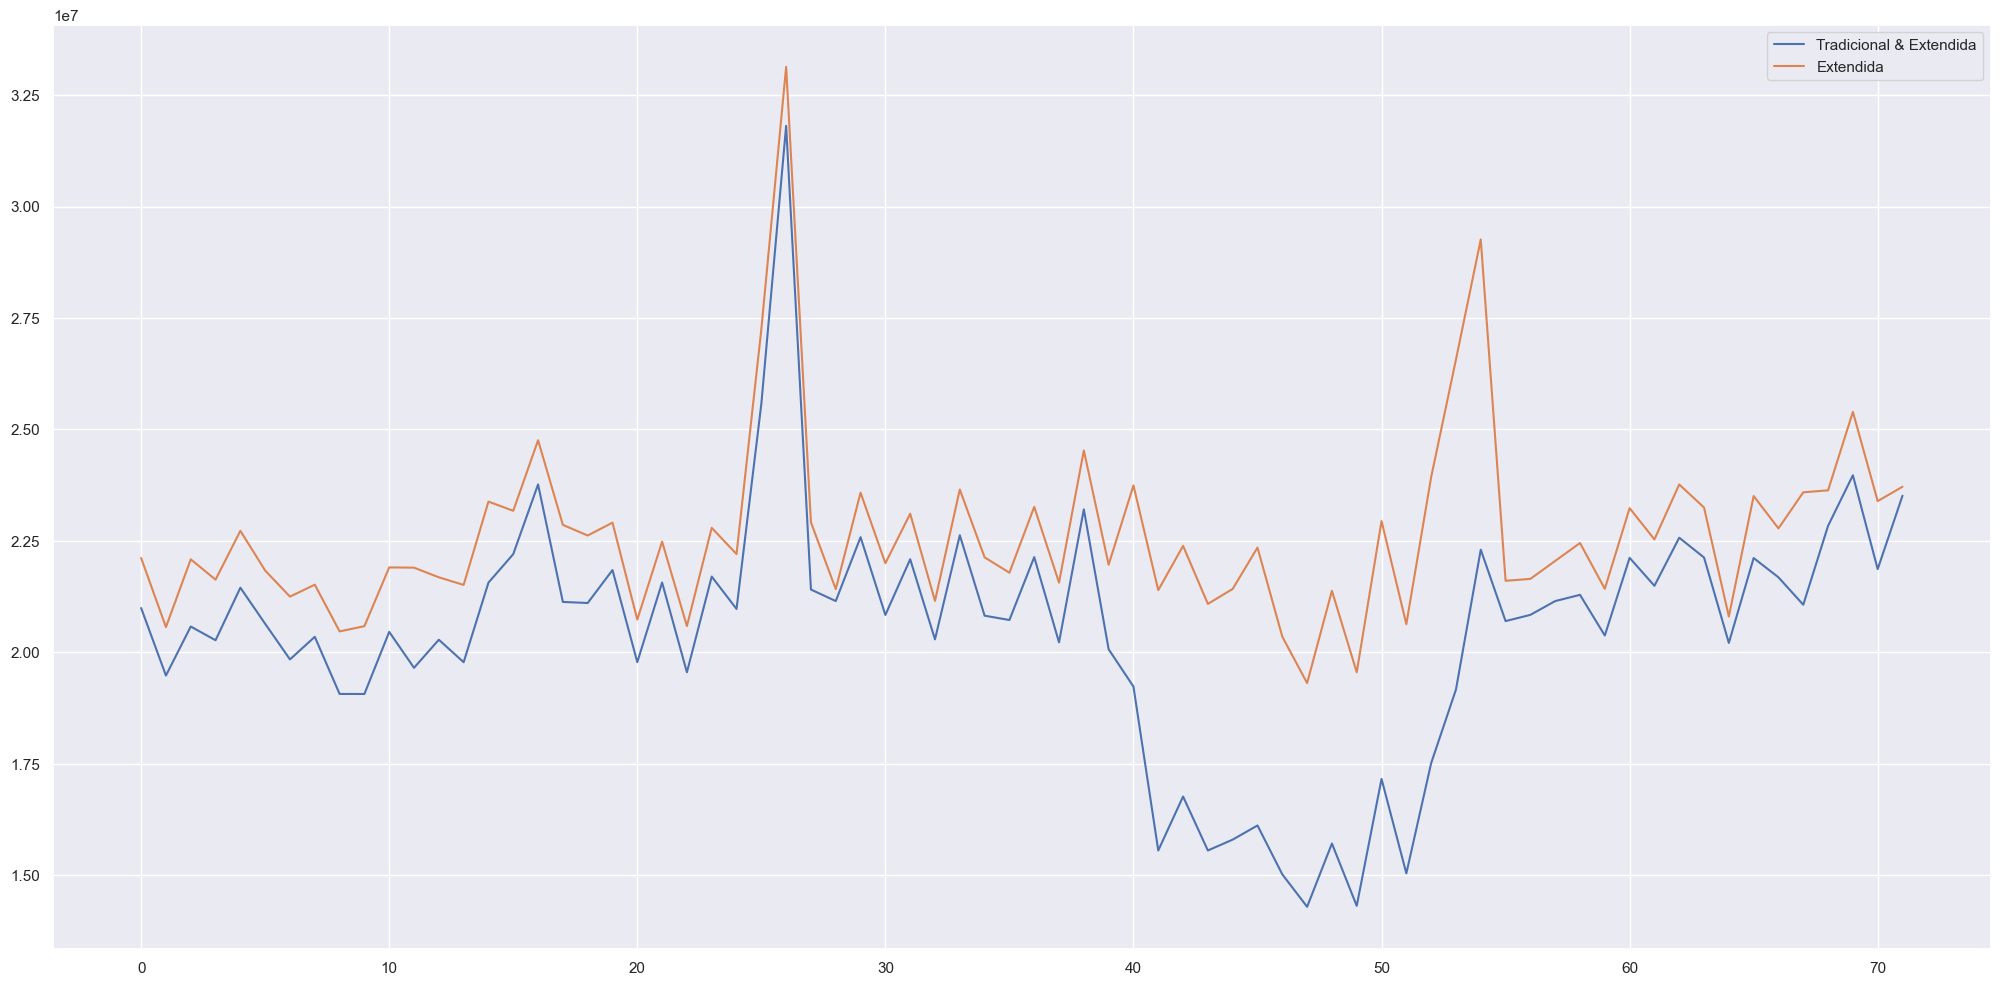

In [41]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);